# Image model finetune


NLP work in progress is in separate notebook

In [1]:
import os
import sys
import json
import yaml

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/kaggle/input/flipkart/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [4]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
import re

In [6]:
get_main_category = lambda example: re.findall("^.+?(?= >>|$)", example)[0]

df["main_product_category"] = df["product_category_tree"].apply(get_main_category)

In [7]:
df["main_product_category"].value_counts()

main_product_category
["Home Furnishing               150
["Baby Care                     150
["Watches                       150
["Home Decor & Festive Needs    150
["Kitchen & Dining              150
["Beauty and Personal Care      150
["Computers                     150
Name: count, dtype: int64

In [8]:
# !!!!!! ah the remove the [" O_o
df["main_product_category"] = df["main_product_category"].apply(lambda example: example[2:])

df["main_product_category"].value_counts()

main_product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

# Open CV stuff and SIFT features


[https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

## References / credit : following ressources lien

- tuto/webinaire OC : Weather firt analysis notebook


### Image info in dataframe

it is in the `image` column to get the JPG names

In [9]:
# get a CATEGORY2ID MAPPING
category2id = {k:v
                 for k,v in zip(
                     set(df["main_product_category"].unique()),
                     range(7)
                 )
                }

df["category_id"] = df["main_product_category"].apply(lambda x: category2id[x])

df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,category_id
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,6
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,6
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1


In [10]:
from os import listdir

path = "/kaggle/input/flipkart/Flipkart/Images"

list_photos = [file.lstrip('0') for file in listdir(path)]

print(len(list_photos))

1050


# Show examples of each label

In [11]:
from matplotlib.image import imread


# changed "data" to "df" here and
# df['main_product_category']


def list_fct(name) :
    list_image_name = df[df['main_product_category'] == name]['image']
    return list(list_image_name)

In [12]:
df['main_product_category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [13]:
"""
list_cloudy=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="cloudy"]
list_rain=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="rain"]
list_shine=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="shine"]
list_sunrise=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="sunrise"]
"""
list_home_furnishing = list(df[df['main_product_category'] == 'Home Furnishing']['image'])
list_baby_care = list(df[df['main_product_category'] == 'Baby Care']['image'])
list_watches = list(df[df['main_product_category'] == 'Watches']['image'])
list_home_decor = list(df[df['main_product_category'] == 'Home Decor & Festive Needs']['image'])
list_kitchen = list(df[df['main_product_category'] == 'Kitchen & Dining']['image'])
list_beauty = list(df[df['main_product_category'] == 'Beauty and Personal Care']['image'])
list_computers = list(df[df['main_product_category'] == 'Computers']['image'])

Home Furnishing


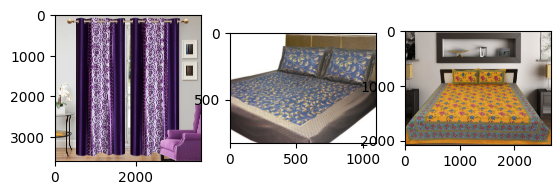

Baby Care


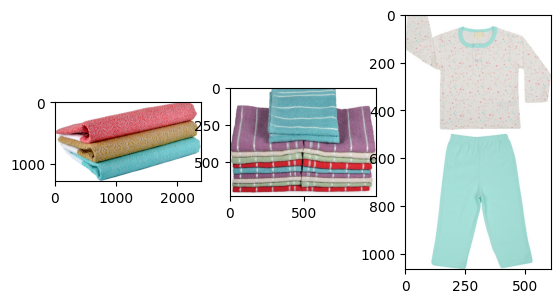

Watches


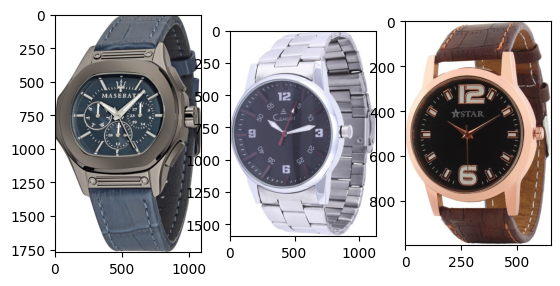

Home Decor & Festive Needs


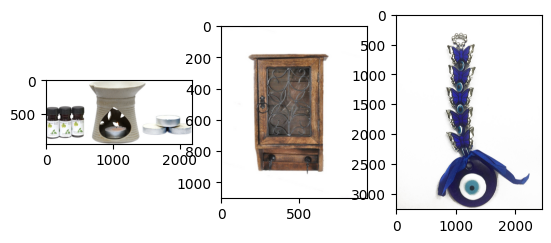

Kitchen & Dining


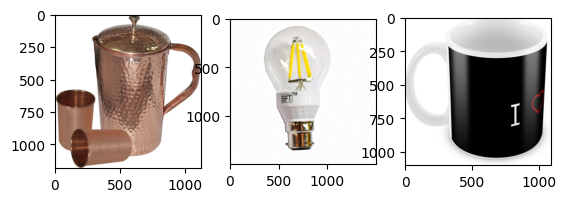

Beauty and Personal Care


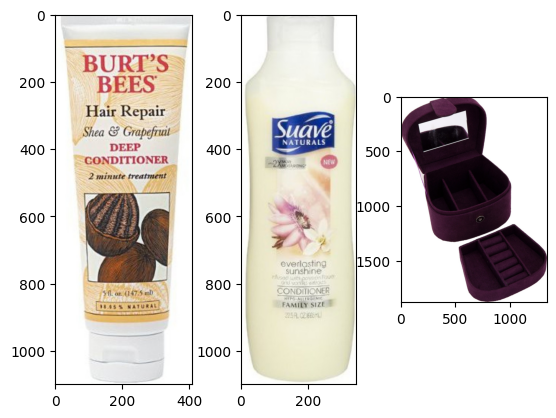

Computers


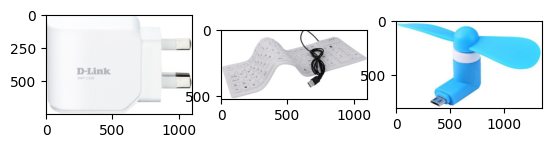

In [14]:
# "list labels" is the values possible for the product 
list_labels = list(df['main_product_category'].unique())

for name in list_labels:
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        #filename = path + list_fct(name)[i+10]
        filename = os.path.join(path, list_fct(name)[i])
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Image preparation

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical



In [16]:
from sklearn import preprocessing

# Images stuff

In [17]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,category_id
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,6
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,6
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1


In [18]:
df.tail()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,category_id
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,6
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,6
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,6
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,6
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack...",Baby Care,6


In [19]:
prepared_images = []

for name in list_labels:
    print(name)
    # print("-------")
    for i in range(150):
        if i % 20 == 0:
            print(name, i)
        filename = os.path.join(path, list_fct(name)[i])
        #image = imread(filename)
        #
        # DEBUG:
        # https://stackoverflow.com/questions/67183501/setting-an-array-element-with-a-sequence-requested-array-has-an-inhomogeneous-sh
        # ?????
        image = load_img(path=filename, target_size=(224,224), color_mode='rgb') # conv mentor - erreurs avec code tuto?????
        #plt.imshow(image)
        img = img_to_array(image)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2])) # conv mentor, tuto errerur???
        img = preprocess_input(img)
        prepared_images.append(img[0])


Home Furnishing
Home Furnishing 0
Home Furnishing 20
Home Furnishing 40
Home Furnishing 60
Home Furnishing 80
Home Furnishing 100
Home Furnishing 120
Home Furnishing 140
Baby Care
Baby Care 0
Baby Care 20
Baby Care 40
Baby Care 60
Baby Care 80
Baby Care 100
Baby Care 120
Baby Care 140
Watches
Watches 0
Watches 20
Watches 40
Watches 60
Watches 80
Watches 100
Watches 120
Watches 140
Home Decor & Festive Needs
Home Decor & Festive Needs 0
Home Decor & Festive Needs 20
Home Decor & Festive Needs 40
Home Decor & Festive Needs 60
Home Decor & Festive Needs 80
Home Decor & Festive Needs 100
Home Decor & Festive Needs 120
Home Decor & Festive Needs 140
Kitchen & Dining
Kitchen & Dining 0
Kitchen & Dining 20
Kitchen & Dining 40
Kitchen & Dining 60
Kitchen & Dining 80
Kitchen & Dining 100
Kitchen & Dining 120


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Kitchen & Dining 140
Beauty and Personal Care
Beauty and Personal Care 0
Beauty and Personal Care 20
Beauty and Personal Care 40
Beauty and Personal Care 60
Beauty and Personal Care 80
Beauty and Personal Care 100
Beauty and Personal Care 120
Beauty and Personal Care 140
Computers
Computers 0
Computers 20
Computers 40
Computers 60
Computers 80
Computers 100
Computers 120
Computers 140


In [20]:
images_np = np.array(prepared_images)

In [21]:
images_np.shape 

(1050, 224, 224, 3)

In [22]:
X = images_np
y = to_categorical(df['category_id'])

In [23]:
ids = df.index

X_train_and_val, X_test, y_train_and_val, y_test, ids_train_and_val, ids_test = train_test_split(X, y, ids, stratify=y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X_train_and_val, y_train_and_val, ids_train_and_val, stratify=y_train_and_val, test_size=0.12, random_state=42)



In [24]:
X_train.shape

(831, 224, 224, 3)

In [25]:
X_val.shape

(114, 224, 224, 3)

In [26]:
X_test.shape

(105, 224, 224, 3)

# Model loading

In [27]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    #predictions = Dense(4, activation='softmax')(x)
    predictions = Dense(7, activation='softmax')(x) # <--- care, 7 labels for us 4 in tuto

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [28]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [29]:
print("=============== 10 EPOCHS WHILE DEBUGG =================")
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=10, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

=============== 10 EPOCHS WHILE DEBUGG =================
Epoch 1/10


I0000 00:00:1726439849.511463     112 service.cc:145] XLA service 0x79cca4206300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726439849.511520     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726439849.511526     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726439872.188501     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1909 - loss: 11.8897   
Epoch 1: val_loss improved from inf to 3.53382, saving model to ./model1_best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.1932 - loss: 11.7230 - val_accuracy: 0.2632 - val_loss: 3.5338
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2486 - loss: 5.0547
Epoch 2: val_loss improved from 3.53382 to 2.95408, saving model to ./model1_best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.2496 - loss: 5.0179 - val_accuracy: 0.2719 - val_loss: 2.9541
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3164 - loss: 3.0025
Epoch 3: val_loss improved from 2.95408 to 2.59965, saving model to ./model1_best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.3173 - loss: 2.9868 - val_accuracy: 0.2719 - val_loss: 2.5996
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.4343 - loss: 1.9812
Epoch 4: val_loss improved from 

In [30]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 687ms/step - accuracy: 0.9207 - loss: 0.3917
Training Accuracy: 0.9206

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2640 - loss: 2.6669 
Validation Accuracy:  0.2719


In [31]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.2719
Test Accuracy       :  0.3238


In [33]:
!pip install plot_keras_history

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of plot-keras-history to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9218 sha256=7aa44ed2de6056f641d51d3b38aaaf1b14fc8ec7a23861c7013e7100f6de07c4
  Stored in directory: /root/.cache/pip/wheels/f2/3d/9d/f6f3bbee314c8cc369277b721b41ac4ab8b790df199ed7d1ad
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.1.0-py3-none-any.whl size=323547 sha256=981b2f900b3aeb34d470f5142ddcac0f858a5b9c0923631fd0abfa2ed69108c2
  Stored in directory: /root/.cache/pip/wheels/79/89/fb/06b588eac70ca5d414815235b4443fa867402a

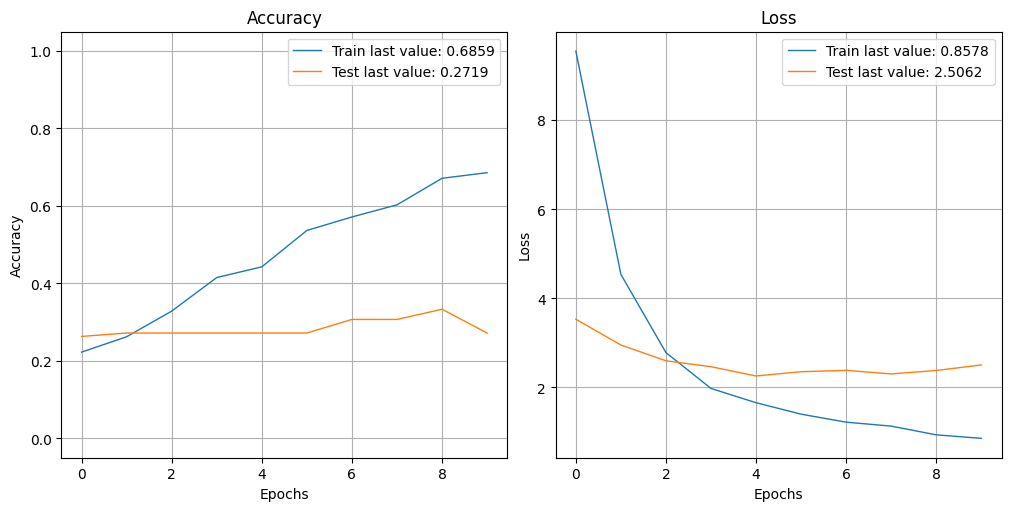

In [34]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [35]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
[2 3 6 1 5 5 2 4 2 4 5 6 3 4 4 2 4 5 5 0 6 5 1 3 0 3 6 6 0 0 2 0 2 2 1 6 6
 3 3 6 2 5 0 1 6 1 1 5 4 3 3 6 6 6 0 2 3 4 3 4 4 6 3 3 0 1 2 5 5 0 5 0 0 0
 4 2 1 5 3 2 1 4 2 5 1 3 0 0 6 4 4 1 4 0 5 4 1 1 0 1 5 5 0 2 2 3 6 2 1 6 1
 3 3 4]

[4 3 0 6 4 4 0 5 2 0 2 3 4 3 4 0 0 4 2 0 4 5 4 5 2 3 4 6 3 3 1 3 0 0 1 1 3
 1 1 0 0 4 0 3 4 4 3 6 4 3 3 0 6 6 0 4 3 4 5 6 4 0 3 5 0 0 0 6 2 3 6 0 3 2
 1 0 0 2 3 1 3 3 2 0 1 0 2 0 6 1 5 1 5 3 1 5 2 3 2 5 0 3 2 6 4 0 6 2 1 2 1
 2 0 2]


In [37]:
from sklearn import cluster, metrics

In [38]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[6 0 5 6 0 0 0]
 [2 5 1 4 2 1 1]
 [7 2 3 0 3 0 1]
 [3 2 1 7 1 3 0]
 [2 2 1 2 4 4 1]
 [2 1 4 1 4 1 3]
 [4 1 1 2 3 0 5]]


In [39]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [40]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [2 1 0 3 4 4 6]
[[5 0 6 6 0 0 0]
 [1 5 2 4 3 0 1]
 [3 2 7 0 3 0 1]
 [1 2 3 7 4 0 0]
 [1 2 2 2 8 0 1]
 [4 1 2 1 5 0 3]
 [1 1 4 2 3 0 5]]

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        17
           1       0.38      0.31      0.34        16
           2       0.27      0.44      0.33        16
           3       0.32      0.41      0.36        17
           4       0.31      0.50      0.38        16
           5       0.00      0.00      0.00        16
           6       0.45      0.31      0.37        16

    accuracy                           0.32       114
   macro avg       0.29      0.32      0.30       114
weighted avg       0.29      0.32      0.30       114



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

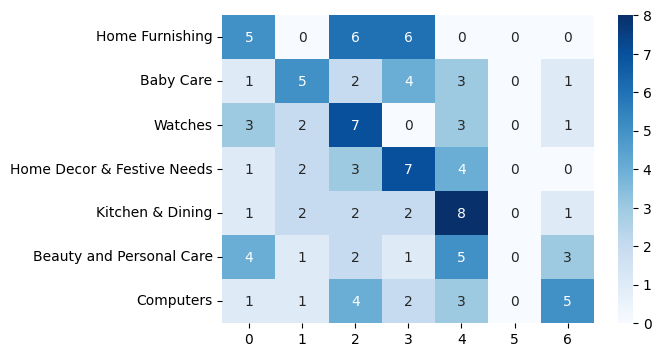

In [42]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")